In [1]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
import tensorflow
from keras import layers
from tensorflow.keras.applications.densenet import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

In [2]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign = np.array(Dataset_loader(r'C:\Users\USER\Python Files\Breast Cancer Datasets\benign',224))
malign = np.array(Dataset_loader(r'C:\Users\USER\Python Files\Breast Cancer Datasets\malign',224))

100%|██████████| 127/127 [00:04<00:00, 28.11it/s]


In [3]:
# Creating our independent and dependent features:
benign_label = np.zeros(len(benign))
malign_label = np.ones(len(malign))

In [4]:
X = np.concatenate((benign, malign), axis = 0)
Y = np.concatenate((benign_label, malign_label), axis = 0)

In [5]:
# Shuffling the data as we have one class as values then another class as values in my data thorugh concatemnation:
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
Y = Y[s]

Y = to_categorical(Y, num_classes= 2)

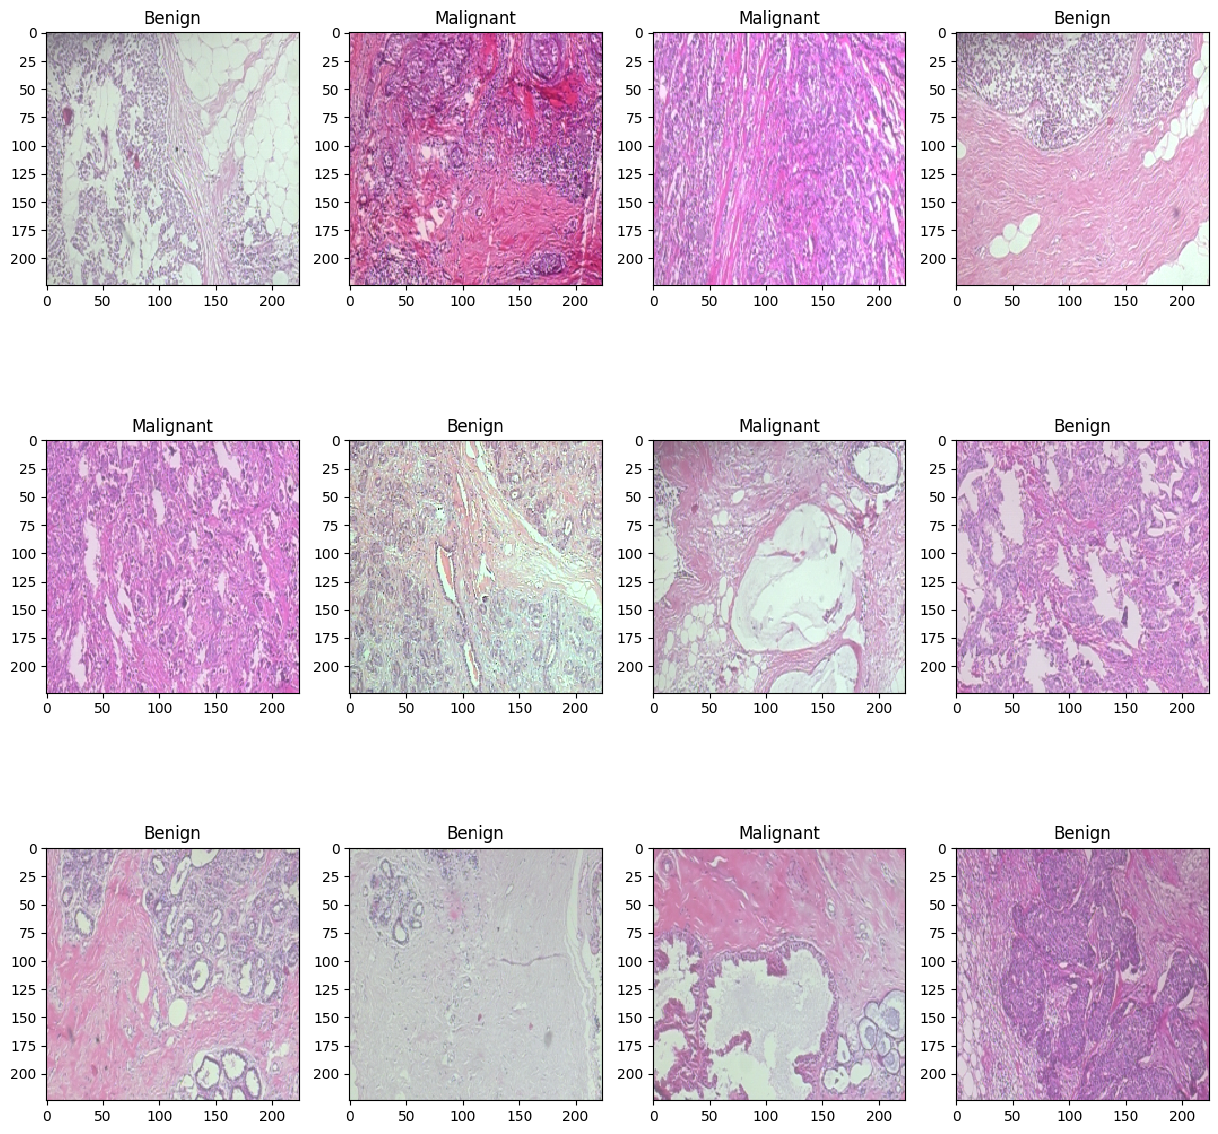

In [6]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [7]:
# Image preprocessing part - 2

BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )


In [8]:

def build_model(backbone, lr=1e-3):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    return model

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (Batch  (None, 1920)              7680      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18333506 (69.94 MB)
Trainable params: 1810

In [9]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)


history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=4,
    validation_data=(x_val, y_val),
)

C:\Users\USER\AppData\Local\Temp\ipykernel_6004\1283509736.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/4
11/11 [==============================] - 729s 49s/step - loss: 0.6452 - accuracy: 0.7539 - val_loss: 17.5533 - val_accuracy: 0.5000
Epoch 2/4
11/11 [==============================] - 608s 50s/step - loss: 0.4490 - accuracy: 0.8010 - val_loss: 118.6588 - val_accuracy: 0.4792
Epoch 3/4
11/11 [==============================] - 654s 55s/step - loss: 0.2706 - accuracy: 0.8743 - val_loss: 195.4012 - val_accuracy: 0.4792
Epoch 4/4
11/11 [==============================] - 626s 53s/step - loss: 0.3073 - accuracy: 0.8534 - val_loss: 406.1858 - val_accuracy: 0.4792


<Axes: >

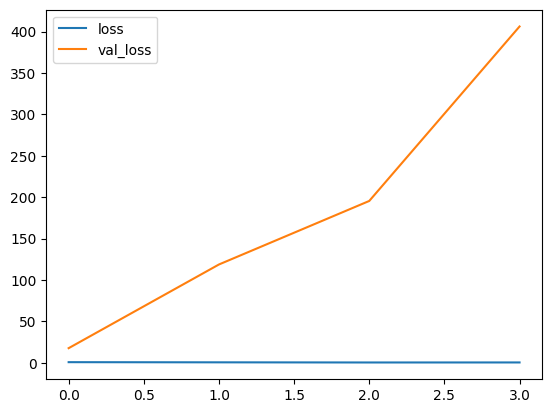

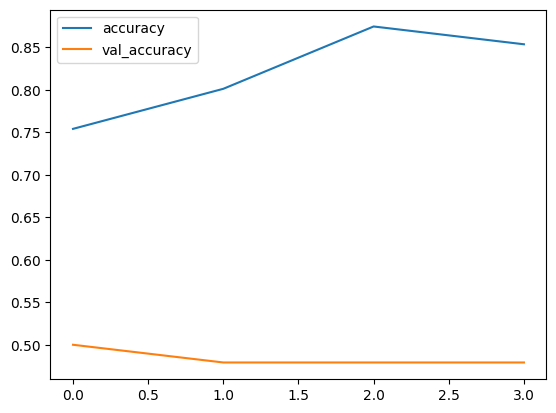

In [10]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [11]:
# Saving the tokenizer and the model:

import pickle

pickle.dump(train_generator, open(r'C:\Users\USER\Python Files\image-generator-model.pkl', 'wb'))
model.save(r'C:\Users\USER\Python Files\breast-cancer-model.h5')

C:\Users\USER\anaconda3\envs\DataFrame\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
